In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("default")

# Paths (same as Day-1)
BASE_DIR = "../data"
IMG_DIR = os.path.join(BASE_DIR, "images")
GT_DIR = os.path.join(BASE_DIR, "masks_gt")
PRED_DIR = os.path.join(BASE_DIR, "masks_pred")


In [2]:
#Helper: Load Image + Mask
def load_sample(idx):
    img = cv2.imread(f"{IMG_DIR}/{idx}.png", 0)
    gt = cv2.imread(f"{GT_DIR}/{idx}.png", 0)
    pred = cv2.imread(f"{PRED_DIR}/{idx}.png", 0)
    return img, gt, pred


In [3]:
#Heuristic 1: Area Anomaly
def area_anomaly(mask, reference=None):
    area = np.sum(mask > 0)
    if reference is not None:
        ref_area = np.sum(reference > 0)
        ratio = area / (ref_area + 1e-6)
        if ratio < 0.5 or ratio > 1.5:
            return True, ratio
        return False, ratio
    else:
        # if no reference, just check absolute threshold
        return area < 500 or area > 10000, area


In [4]:
#Heuristic 2: Shape Irregularity (Compactness)
def shape_irregularity(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return 1e6  # extreme irregular
    area = sum(cv2.contourArea(c) for c in contours)
    perimeter = sum(cv2.arcLength(c, True) for c in contours)
    compactness = (perimeter**2) / (4 * np.pi * area + 1e-6)
    return compactness


In [5]:
#Heuristic 3: Fragment Count
def fragment_count(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return len(contours)


In [12]:
#Combine Heuristics
def detect_errors(pred_mask, gt_mask=None):
    errors = {}

    # Area
    area_flag, area_value = area_anomaly(pred_mask, gt_mask)
    errors["area_anomaly"] = area_flag
    errors["area_ratio"] = area_value

    # Shape
    shape_val = shape_irregularity(pred_mask)
    errors["shape_irregularity"] = shape_val
    errors["shape_flag"] = shape_val > 1.5  # threshold, tune later

    # Fragmentation
    frag_val = fragment_count(pred_mask)
    errors["fragment_count"] = frag_val
    errors["fragment_flag"] = frag_val > 1

    # Combine
    errors["any_error"] = area_flag or errors["shape_flag"] or errors["fragment_flag"]

    return errors


Compactness: 1.76, Fragments: 2, Area ratio: 1.16
{'area_anomaly': False, 'area_ratio': 1.1605589830401726, 'shape_irregularity': 1.7552884196696292, 'shape_flag': True, 'fragment_count': 2, 'fragment_flag': True, 'any_error': True}


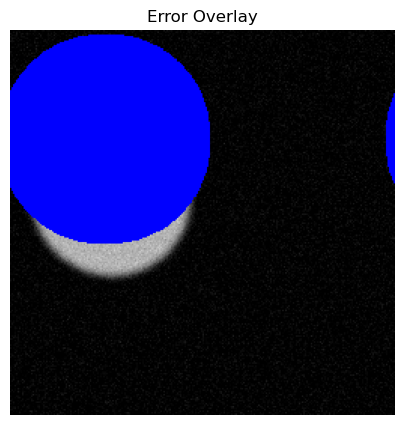

In [18]:
idx = 3
img, gt, pred = load_sample(idx)
errors = detect_errors(pred, gt)
print(f"Compactness: {shape_irregularity(pred):.2f}, Fragments: {fragment_count(pred)}, Area ratio: {errors['area_ratio']:.2f}")
print(errors)

def overlay_errors(img, pred, errors):
    overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    if errors["area_anomaly"]:
        overlay[pred>0] = [255,0,0]  # Red for area anomaly
    if errors["shape_flag"]:
        overlay[pred>0] = [0,255,255]  # Yellow for shape
    if errors["fragment_flag"]:
        overlay[pred>0] = [0,0,255]  # Blue for fragmentation

    plt.figure(figsize=(5,5))
    plt.imshow(overlay)
    plt.title("Error Overlay")
    plt.axis("off")
    plt.show()
overlay_errors(img, pred, errors)

Sample 0: {'area_anomaly': False, 'area_ratio': 1.204438466576503, 'shape_irregularity': 1.1764752773625577, 'shape_flag': False, 'fragment_count': 1, 'fragment_flag': False, 'any_error': False}


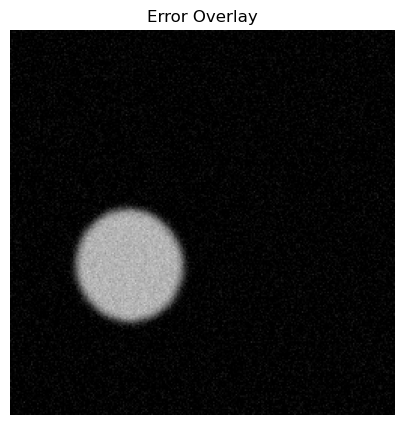

Sample 5: {'area_anomaly': False, 'area_ratio': 0.8323287670092699, 'shape_irregularity': 1.325458199078299, 'shape_flag': False, 'fragment_count': 1, 'fragment_flag': False, 'any_error': False}


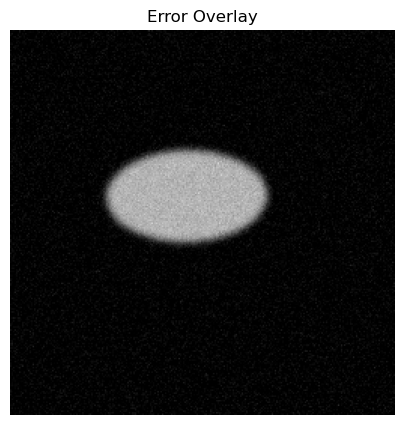

Sample 10: {'area_anomaly': True, 'area_ratio': 5.398586455391422, 'shape_irregularity': 21.39023617249558, 'shape_flag': True, 'fragment_count': 74, 'fragment_flag': True, 'any_error': True}


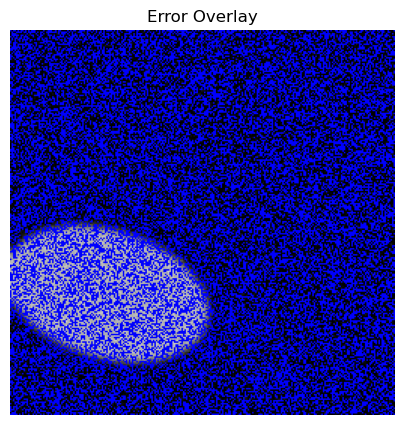

Sample 15: {'area_anomaly': False, 'area_ratio': 1.3005056582469285, 'shape_irregularity': 1.1430395599997047, 'shape_flag': False, 'fragment_count': 1, 'fragment_flag': False, 'any_error': False}


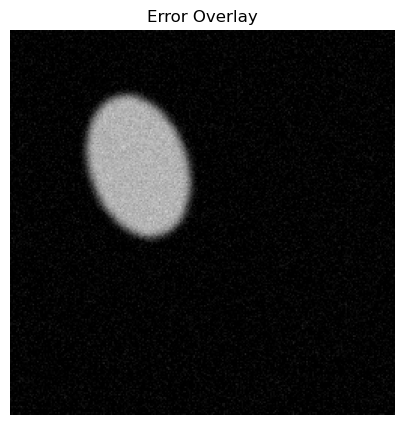

In [19]:
#Batch Detection
for idx in [0,5,10,15]:
    img, gt, pred = load_sample(idx)
    errors = detect_errors(pred, gt)
    print(f"Sample {idx}: {errors}")
    overlay_errors(img, pred, errors)
